<a href="https://colab.research.google.com/github/Ajayrawati/Dogs_And_Cats/blob/main/Dogs_and_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install kaggle
!pip install -p kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats
!unzip dogs-vs-cats.zip
!unzip test1.zip
!unzip train.zip


Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

In [4]:
import pandas as pd
import numpy as np
import os
path = pd.read_csv("sampleSubmission.csv")
path.head()


images = "./train"
file_names = os.listdir(images)

In [5]:
def to_dataframe(file_names):
    files,labels = list(),list()
    for file  in file_names:
        files.append(file)
        labels.append(file[:3])
    df = pd.DataFrame({'filenames':files,'Labels':labels})
    return  df

In [6]:
df =to_dataframe(file_names)
df.head()

,filenames,Labels
0,dog.3946.jpg,dog
1,cat.7701.jpg,cat
2,cat.2313.jpg,cat
3,dog.10699.jpg,dog
4,cat.7191.jpg,cat


Data set label distribution 
: Labels
dog    12500
cat    12500
Name: count, dtype: int64


<Axes: xlabel='Labels', ylabel='count'>

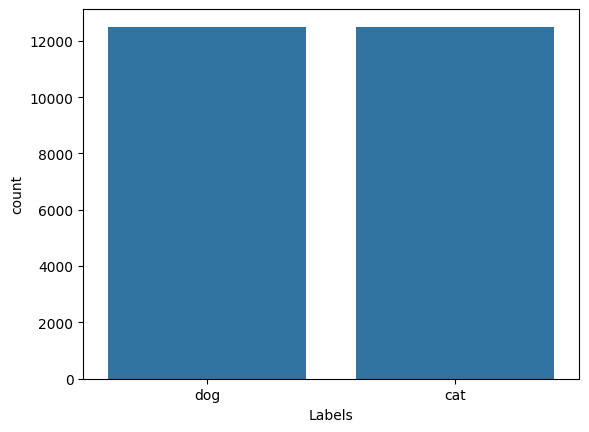

In [7]:
import seaborn as sns
print('Data set label distribution \n:', df['Labels'].value_counts())

sns.countplot(x= df['Labels'])

In [8]:
cat = [file for file in file_names if file[:3]=='cat']
dogs = [file for file in file_names if file[:3]=='dog']

(374, 500, 3)


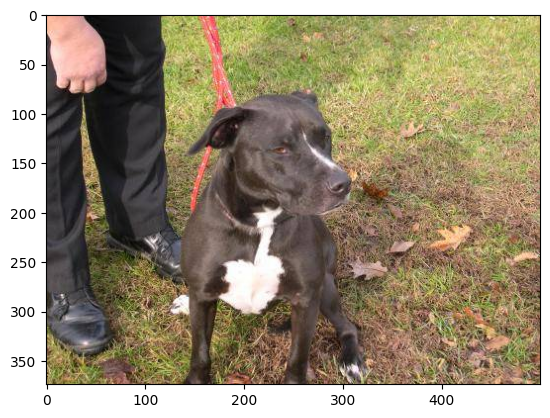

In [9]:
import matplotlib.image as im
import matplotlib.pyplot as plt
image = im.imread('./train/dog.11232.jpg')
print(image.shape)
plt.imshow(image)

(312, 355, 3)


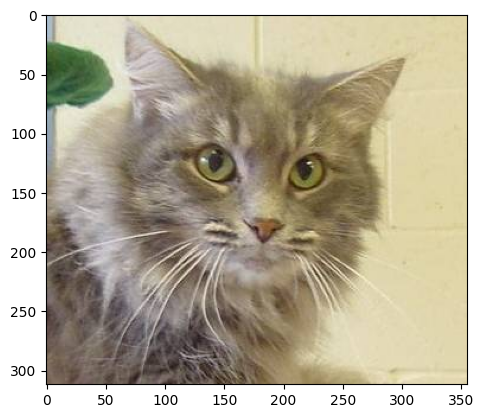

In [10]:
image = im.imread('./train/cat.12232.jpg')
print(image.shape)
plt.imshow(image)

In [11]:
from sklearn.model_selection import train_test_split
seed = 0
train_set, validation_set = train_test_split(df,test_size=0.2,random_state=seed)

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
width, height = 150,150
batch_size = 32
df


,filenames,Labels
0,dog.3946.jpg,dog
1,cat.7701.jpg,cat
2,cat.2313.jpg,cat
3,dog.10699.jpg,dog
4,cat.7191.jpg,cat
...,...,...
24995,cat.11964.jpg,cat
24996,cat.4419.jpg,cat
24997,cat.4007.jpg,cat
24998,dog.9663.jpg,dog


In [13]:
train_datagen=ImageDataGenerator(rescale=1./255, #rescaling the pixels
                                 rotation_range=15, #rotate the image for better prediction
                                 zoom_range=0.2,
                                 shear_range = 0.1,
                                 horizontal_flip = True,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1
                                )
training_data = train_datagen.flow_from_dataframe(dataframe=df,
                                                 directory='./train',
                                                 x_col = 'filenames',#feature
                                                 y_col='Labels',#target
                                                 target_size=(width,height),#same height,width for all data
                                                 class_mode='categorical',# reads data like one_hot_encoding, binary works like label encoder
                                                 batch_size=batch_size) #increase read speed



Found 25000 validated image filenames belonging to 2 classes.


In [14]:
training_data.class_indices

{'cat': 0, 'dog': 1}

In [15]:
validation_datagen=ImageDataGenerator(rescale=1./255) #rescaling the pixel
validation_data = validation_datagen.flow_from_dataframe(dataframe=validation_set,
                                                 directory='./train',
                                                 x_col = 'filenames',#feature
                                                 y_col='Labels',#target
                                                 target_size=(width,height),#same height,width for all data
                                                 class_mode='categorical',# reads data like one_hot_encoding, binary works like label encoder
                                                 batch_size=batch_size) #increase read speed

Found 5000 validated image filenames belonging to 2 classes.


In [16]:
def build_model(hp):
    model = keras.Sequential([
        layers.Conv2D(
            filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
            kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
            activation='relu',
            input_shape=(width, height, 3)
        ),
        layers.Conv2D(
            filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
            kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
            activation='relu'
        ),
        layers.Flatten(),
        layers.Dense(
            units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
            activation='relu'
        ),
        layers.Dense(2, activation='softmax')  # Change to 2 if you have two classes
    ])

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
                  loss='categorical_crossentropy',  # Change to categorical if labels are one-hot
                  metrics=['accuracy'])

    model.summary()

    return model


In [19]:
from keras_tuner import RandomSearch
import keras
from keras import layers, Sequential
from keras.layers import Dense, Dropout
from keras.utils  import plot_model
tuner_search = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=1,
    directory='my_dir',
    project_name='DOgsCats'
)

# Start the hyperparameter search
tuner_search.search(training_data,
                    epochs=3,  # Adjust as needed
                    validation_data=validation_data)


Trial 3 Complete [00h 12m 26s]
val_accuracy: 0.5774000287055969

Best val_accuracy So Far: 0.5774000287055969
Total elapsed time: 00h 39m 44s


In [20]:
model=tuner_search.get_best_models(num_models=1)[0]
from keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss',patience=4,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=4,min_lr=0.0001,factor=0.5)
checkpoint = ModelCheckpoint('model.keras',save_best_only=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 146, 146, 48)        │           3,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 142, 142, 64)        │          76,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1290496)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 80)                  │     103,239,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             162 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 103,320,434 (394.14 MB)

 Trainable params: 103,320,434 (394.14 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [21]:
modelt = model.fit(training_data,
                    validation_data=validation_data,

                    epochs=100,steps_per_epoch = 15,

                   validation_steps = validation_set.shape[0]//batch_size)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 978ms/step - accuracy: 0.4948 - loss: 0.6969 - val_accuracy: 0.5012 - val_loss: 0.6965
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.4941 - loss: 0.6973

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 707ms/step - accuracy: 0.4949 - loss: 0.6972 - val_accuracy: 0.8750 - val_loss: 0.6667
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 826ms/step - accuracy: 0.5445 - loss: 0.6919 - val_accuracy: 0.4998 - val_loss: 0.6965
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 863ms/step - accuracy: 0.4702 - loss: 0.6994 - val_accuracy: 0.7500 - val_loss: 0.6654
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5390 - loss: 0.6930 - val_accuracy: 0.5006 - val_loss: 0.6942
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.5374 - loss: 0.6914 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4904 - loss: 0.6942 - val_accuracy: 0.4994 - val_loss: 0.6936
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.4919 - loss: 0.6940 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5059 - loss: 0.6935 - val_accuracy: 0.4988 - va

In [18]:
!pip install keras-tuner
!pip install keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.5 MB/s eta 0:00:00


In [23]:
score = model.evaluate(validation_data)
print('Test Accuracy:',score[1])
print('Test loss:',score[0])

157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.4940 - loss: 0.6959
Test Accuracy: 0.49939998984336853
Test loss: 0.6952102780342102


In [42]:

model.save('model1.keras')


In [25]:
from tensorflow.keras.models import load_model

model1 = load_model('model.keras')

In [26]:
import os
print(os.getcwd())


/content


In [27]:
base_model = keras.applications.vgg16.VGG16(weights='imagenet',include_top=False,input_shape=(width,height,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [28]:
base_model.trainable=False

In [29]:
train_set.shape


(20000, 2)

In [39]:
from tensorflow.keras.layers import *

model = keras.models.Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2,activation='softmax'))

In [32]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [33]:
history = model.fit(training_data,epochs=30,validation_data=validation_data,steps_per_epoch=10)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.5154 - loss: 1.7668 - val_accuracy: 0.5006 - val_loss: 0.7560
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.4944 - loss: 0.7343 - val_accuracy: 0.4994 - val_loss: 0.6746
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5617 - loss: 0.6641 - val_accuracy: 0.7884 - val_loss: 0.6214
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.6353 - loss: 0.6501 - val_accuracy: 0.7142 - val_loss: 0.6181
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.6676 - loss: 0.6414 - val_accuracy: 0.8146 - val_loss: 0.5648
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.6597 - loss: 0.6011 - val_accuracy: 0.8390 - val_loss: 0.5197
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6915 - loss: 0.5768 - val_accuracy: 0.8414 - val_loss: 0.4728
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.7558 - loss: 0.4992 - val_accuracy: 0.8282 - val_loss:

In [34]:
evaluation = model.evaluate(validation_data)
print('Test Accuracy',evaluation[1])
print('Test Accuracy',evaluation[0])

157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - accuracy: 0.8803 - loss: 0.2703
Test Accuracy 0.8827999830245972
Test Accuracy 0.26939186453819275


Text(0.5, 1.0, 'Model Accuracy')

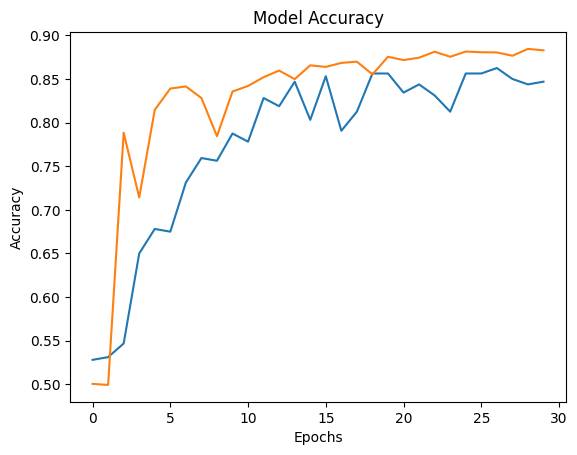

In [35]:
plt.plot(history.history['accuracy'],label= 'Training Accuracy')
plt.plot(history.history['val_accuracy'],label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

In [40]:
model.save('modeltransfer.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:102: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


In [41]:
from tensorflow.keras.models import load_model

model2 = load_model('modeltransfer.keras')

In [43]:
for layers in base_model.layers[0:2]:
    layers.trainable= True

In [44]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [45]:
history = model.fit(training_data,epochs=30,validation_data=validation_data,steps_per_epoch=10)


Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.5287 - loss: 1.3441 - val_accuracy: 0.4998 - val_loss: 0.7713
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5646 - loss: 0.7543 - val_accuracy: 0.7524 - val_loss: 0.5589
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.6720 - loss: 0.6043 - val_accuracy: 0.7864 - val_loss: 0.4744
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.7874 - loss: 0.4650 - val_accuracy: 0.8622 - val_loss: 0.3538
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8035 - loss: 0.4286 - val_accuracy: 0.8754 - val_loss: 0.3053
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8273 - loss: 0.3822 - val_accuracy: 0.8836 - val_loss: 0.2848
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.8607 - loss: 0.3052 - val_accuracy: 0.8888 - val_loss: 0.2634
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8694 - loss: 0.3125 - val_accuracy: 0.8662 - val_loss:

In [46]:
evaluation = model.evaluate(validation_data)
print('Test Accuracy',evaluation[1])
print('Test Accuracy',evaluation[0])

157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.9309 - loss: 0.1704
Test Accuracy 0.9297999739646912
Test Accuracy 0.1702466607093811


In [47]:
model.save('modelfinal.keras')